# Check Down Sampling Code

#### Selecting Observations:
1. `downSelectTimes`: selecting N back-to-back observations per night
1. `getFilesToAverage`: group observations into subsets to be averaged to hit a certain averaged exposure time for a total of num_obs observations in a night.
1. `averageFiles`: ***Not Yet Implemented***
1. `getExpresNeidTimes`: return EXPRES and NEID observations closest in time
1. Dense Days: return densest days.  This isn't a function, but the code might be useful later so I'm including it here.

#### Selecting Training and Validation Subsets:
1. `Npercent`: separates out a random N percent
1. `Nperday`: separates out a random N observations per day
1. `Nperiodic`: separates out points based on a specified periodicity and width
    1. (3,1): every third day
    1. (5.4/60/24,1.5/60/24): every nu_max
1. Masking out large periods of time: this isn't a function, but the code might be useful later so I'm including it here.

#### Generating a Data Set
To test `mkDataSet`, the script where it all comes together, we generate a summary file of an example data set.

In [1]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
import pandas as pd

import sys
sys.path.append('../ESSP4/')
from data import *
from utils import *

## Load in Data

In [2]:
df_dict = {inst:pd.read_csv(os.path.join(solar_dir,f'{inst}_drp.csv')) for inst in instruments}

In [3]:
df_dict['expres'].columns

Index(['File Name', 'Time [MJD]', 'RV [m/s]', 'RV Err. [m/s]', 'Exp. Time [s]',
       'Airmass', 'Quality', 'Start Time [MJD]', 'BERV [km/s]'],
      dtype='object')

## Selecting Observations

In [4]:
days = Time(['2021-05-30','2021-05-31','2021-06-01','2021-06-02','2021-06-03','2021-06-11']).mjd.astype(int)

def getAxes(days):
    num_day = len(days)
    num_row = num_day//3 + (0 if num_day%3==0 else 1)
    fig, axes = plt.subplots(num_row,3,figsize=(4*num_day,4*num_row))
    axes = np.concatenate(axes)

    for iday,d in enumerate(days):
        ax = axes[iday]
        ax.set_title(Time(d,format='mjd').isot.split('T')[0])
        ax.set_ylim(-4,4*len(instruments))
    
    return fig, axes

### `downSelectTimes`

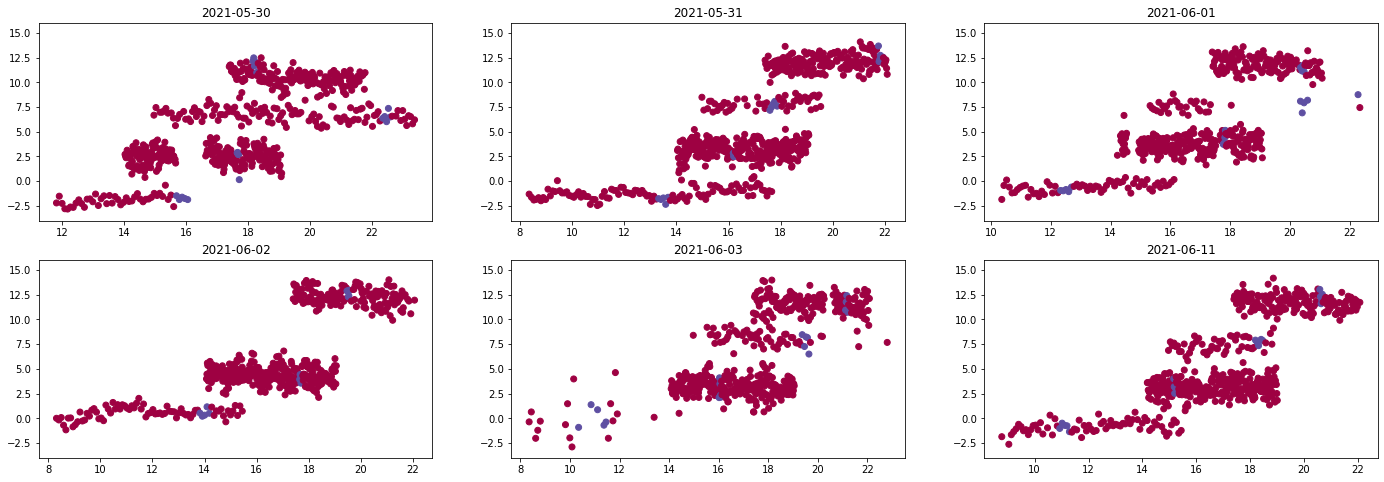

In [5]:
fig, axes = getAxes(days)

for iinst,inst in enumerate(instruments):
    data_df = df_dict[inst]
    time, rvel = data_df.loc[:, ["Time [MJD]","RV [m/s]"]].to_numpy().T
    rvel -= np.nanmedian(rvel)
    tint = time.astype(int)
    obs_mask = downSelectTimes(data_df, num_obs=5)

    for iday,d in enumerate(days):
        ax = axes[iday]
        d_mask = tint==d
        ax.scatter((time[d_mask]-d)*24,rvel[d_mask]+iinst*4,c=obs_mask[d_mask],cmap='Spectral')

### `getFilesToAverage`

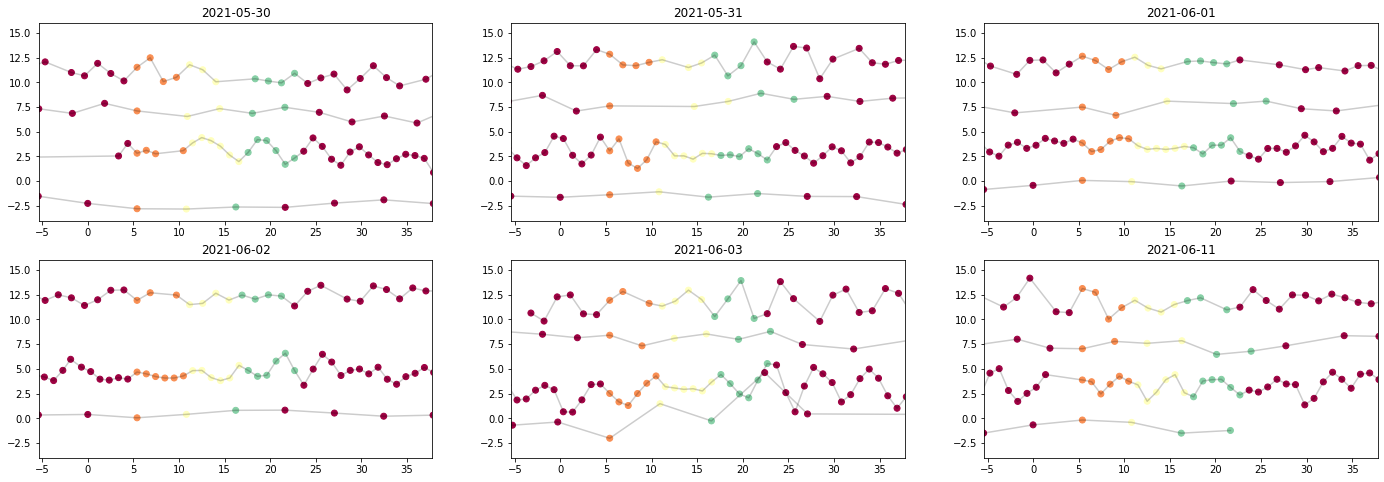

In [6]:
fig, axes = getAxes(days)
target_expt_min = 5.4
target_expt_sec = target_expt_min*60
target_expt_day = target_expt_min/60/24
num_obs = 3

for iinst,inst in enumerate(instruments):
    data_df = df_dict[inst]
    time, rvel = data_df.loc[:, ["Time [MJD]","RV [m/s]"]].to_numpy().T
    rvel -= np.nanmedian(rvel)
    tint = time.astype(int)
    obs_list = getFilesToAverage(data_df,num_obs=num_obs,target_expt=target_expt_sec)

    for iday,d in enumerate(days):
        ax = axes[iday]
        d_mask = tint==d
        # I want to anchor these to the span of averaged observations
        if np.sum(obs_list[d_mask]>0)>0:
            time0 = min(time[d_mask][obs_list[d_mask]>0])-target_expt_day
            vmin = min(obs_list[d_mask][obs_list[d_mask]>0])
            ax.plot((time[d_mask]-time0)*24*60,rvel[d_mask]+iinst*4,'k-',alpha=0.2)
            ax.scatter((time[d_mask]-time0)*24*60,rvel[d_mask]+iinst*4,c=obs_list[d_mask],
                       cmap='Spectral',vmin=vmin-1,vmax=vmin+num_obs)

for ax in axes:
    ax.set_xlim(-target_expt_min,target_expt_min*(num_obs+4))

### `averageFiles`

### `getExpresNeidTimes`

In [7]:
def expresNeidTestPlot(**kwargs):
    fig, axes = getAxes(days)
    obs_df = getExpresNeidTimes(df_dict,**kwargs)
    time, rvel = obs_df.loc[:, ["Time [MJD]","RV [m/s]"]].to_numpy().T
    tint = time.astype(int)

    for iday,d in enumerate(days):
        ax = axes[iday]
        d_mask = tint==d

        if np.sum(d_mask)>0:
            time0 = min(time[d_mask])
            # Plot Original Data
            for iinst,inst in enumerate(['expres','neid']):
                data_df = df_dict[inst]
                inst_time, inst_rvel = data_df.loc[:, ["Time [MJD]","RV [m/s]"]].to_numpy().T
                inst_dmask = inst_time.astype(int)==d
                ax.plot((inst_time[inst_dmask]-time0)*24*60,inst_rvel[inst_dmask],'k.-',alpha=0.2)

            # Plot Selected Data
            ax.scatter((time[d_mask]-time0)*24*60,rvel[d_mask],
                       c=obs_df[d_mask]['Instrument']=='neid',cmap='Spectral')
            t_mask = obs_df[d_mask]['Training'].to_numpy().astype(bool)
            ax.plot((time[d_mask][t_mask]-time0)*24*60,rvel[d_mask][t_mask],
                    color='None',mec='C2',mew=3,ms=10,marker='s',linestyle='None')

    for ax in axes:
        ax.set_ylim(-6,6)
        ax.set_xlim(-15,30)

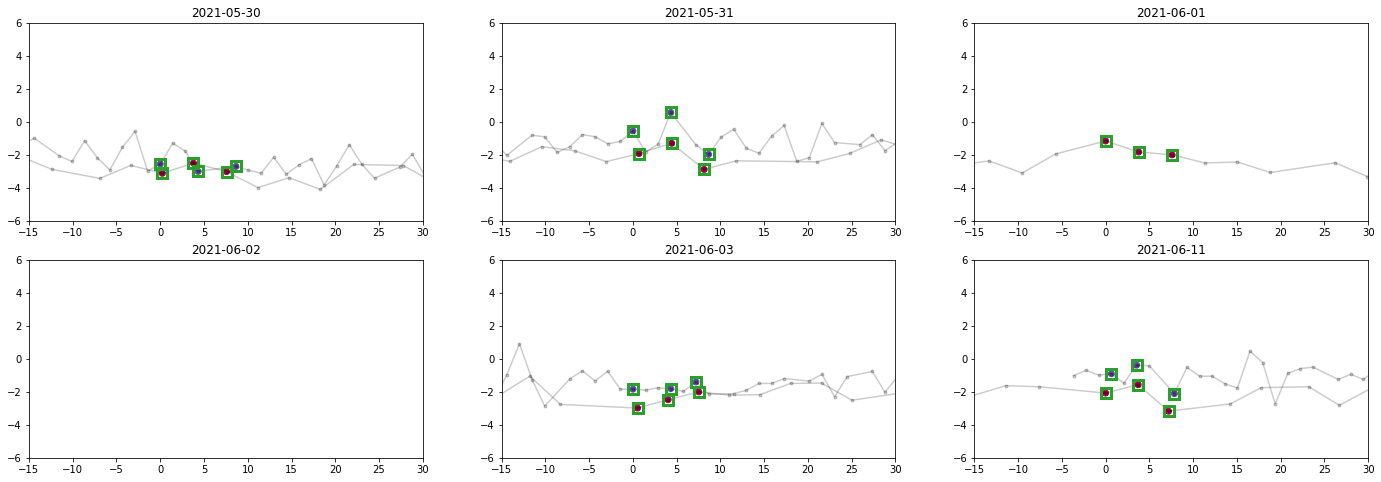

In [8]:
expresNeidTestPlot(num_obs=3,valid_mode=None,num_valid=None)

### Dense Days

In [9]:
# Find the days with the most observations
# That should just be the most dense, right?
day_count = {}
for inst in instruments:
    time = df_dict[inst]['Time [MJD]']
    time_dict = dict(zip(*np.unique(time.astype(int),return_counts=True)))
    for key in time_dict.keys():
        if key not in day_count.keys():
            day_count[key] = 0
        day_count[key] += time_dict[key]

dint_list = np.array(list(day_count.keys()))[np.argsort(list(day_count.values()))[::-1][:4]]
print([t.split('T')[0] for t in Time(dint_list,format='mjd').isot])

['2021-05-31', '2021-06-11', '2021-05-30', '2021-06-20']


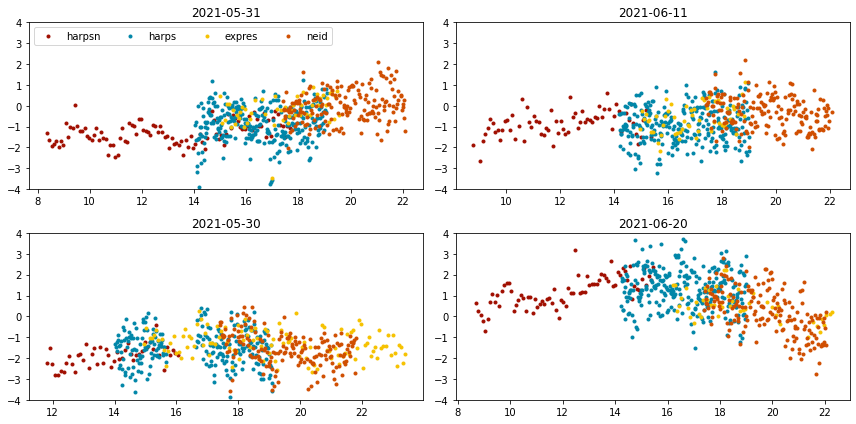

In [10]:
# Plot Dense Days
fig, axes = plt.subplots(2,2,figsize=(12,6))
axes = np.concatenate(axes)
for idint,dint in enumerate(dint_list):
    ax = axes[idint]
    ax.set_title(Time(dint,format='mjd').isot.split('T')[0])
    for iinst, inst in enumerate(instruments):
        time, rvel, errs = df_dict[inst].loc[:, ["Time [MJD]","RV [m/s]","RV Err. [m/s]"]].to_numpy().T
        rvel -= np.nanmedian(rvel)
        dint_mask = time.astype(int)==dint
        ax.plot((time[dint_mask]-dint)*24,rvel[dint_mask],'.',color=inst_cols[iinst],label=inst)
    ax.set_ylim(-4,4)
axes[0].legend(ncol=len(instruments),loc=2)

fig.tight_layout()

## Selecting Training and Validation Subsets

In [11]:
def tvTestPlot(valid_mode, valid_amount, 
               days=days, **kwargs):
    fig, axes = getAxes(days)

    for iinst,inst in enumerate(instruments):
        data_df = df_dict[inst]
        time, rvel = data_df.loc[:, ["Time [MJD]","RV [m/s]"]].to_numpy().T
        rvel -= np.nanmedian(rvel)
        tint = time.astype(int)
        obs_mask = downSelectTimes(data_df, **kwargs)
        
        train_mask = selectValidationSet(data_df[obs_mask],
                                         mode=valid_mode,
                                         validation_amount=valid_amount)
        valid_mask = ~train_mask

        for iday,d in enumerate(days):
            ax = axes[iday]
            d_mask = tint==d
            d_obs_mask = d_mask & obs_mask
            
            # I want to anchor these to the span of selected observations
            if np.sum(d_mask)>0:
                time0 = min(time[d_mask][obs_mask[d_mask]])
                # Plot All Observation
                ax.plot((time[d_mask]-time0)*24*60,rvel[d_mask]+iinst*4,'k.-',alpha=0.2)
                # Plot Selected Observations
                ax.plot((time[obs_mask]-time0)*24*60,rvel[obs_mask]+iinst*4,'C0s',ms=10)
                # Plot Training Observation
                ax.plot((time[obs_mask][train_mask]-time0)*24*60,rvel[obs_mask][train_mask]+iinst*4,'C1o')
                # Plot Validation Observation
                ax.plot((time[obs_mask][valid_mask]-time0)*24*60,rvel[obs_mask][valid_mask]+iinst*4,'kd')

    for ax in axes:
        ax.set_xlim(-15,30)

### `Npercent`: separates out a random N percent

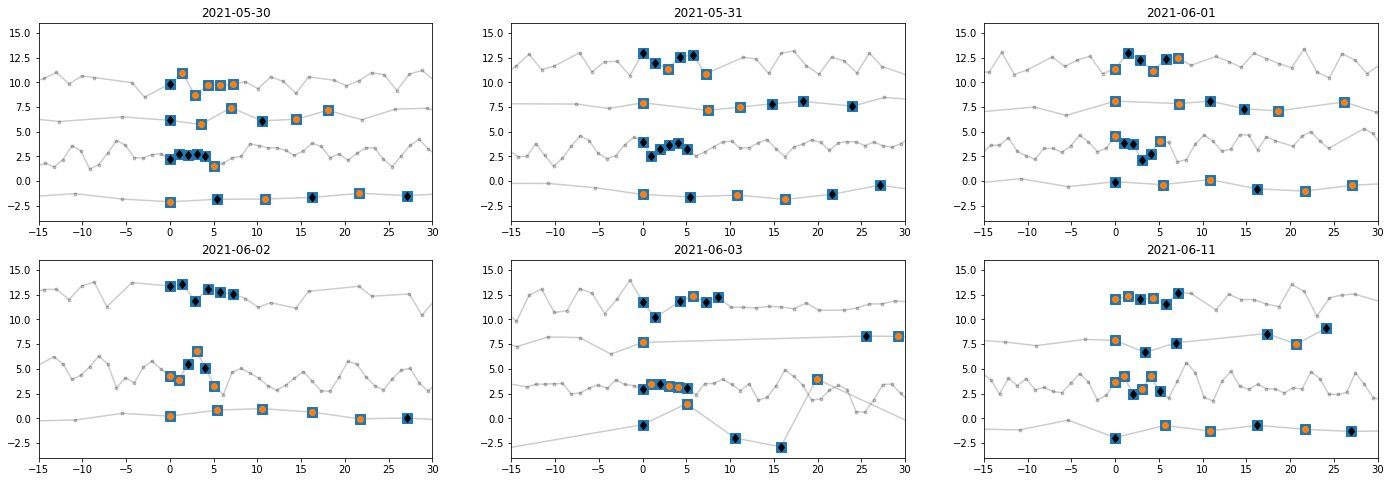

In [12]:
tvTestPlot('Npercent',.5,num_obs=6)

### `Nperday`: separates out a random N observations per day

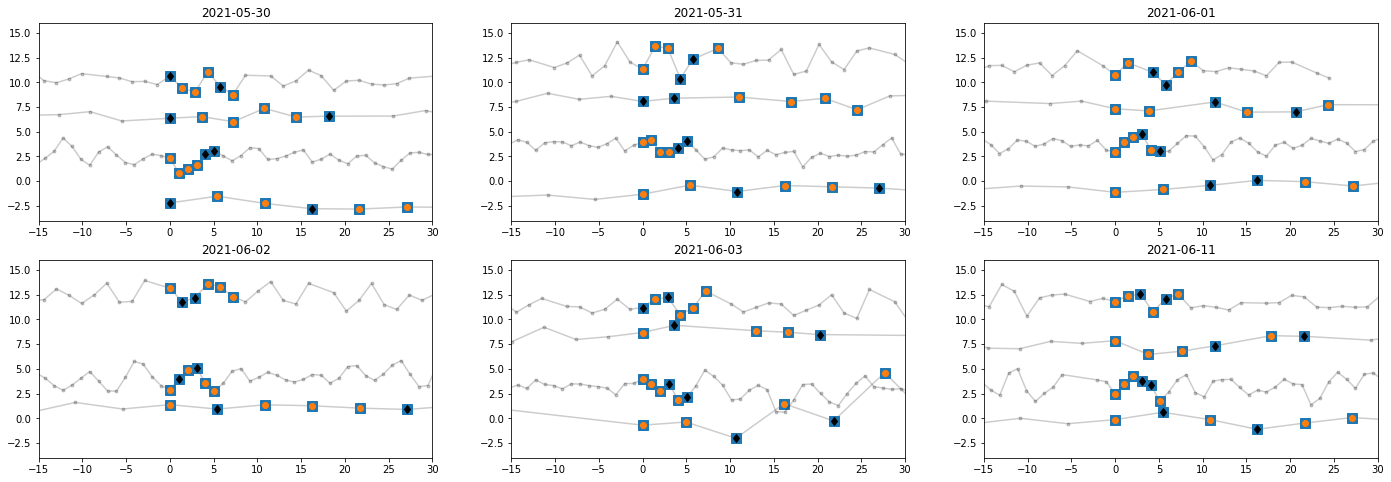

In [13]:
tvTestPlot('Nperday',2,num_obs=6)

### `Nperiodic`: separates out points based on a specified periodicity and width
In `mkDataSet`, this is run on the combined data set so that periodic anchor points are the same across all instruments.

#### (3,1): every third day

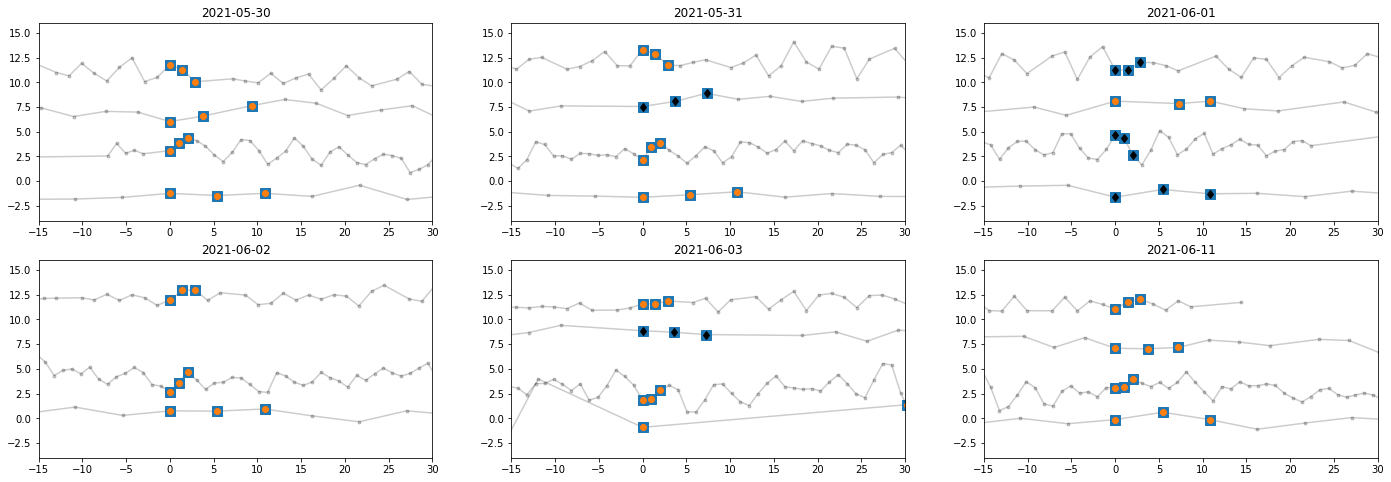

In [14]:
tvTestPlot('Nperiodic',(3,1))

#### (5.4/60/24,1.5/60/24): every nu_max

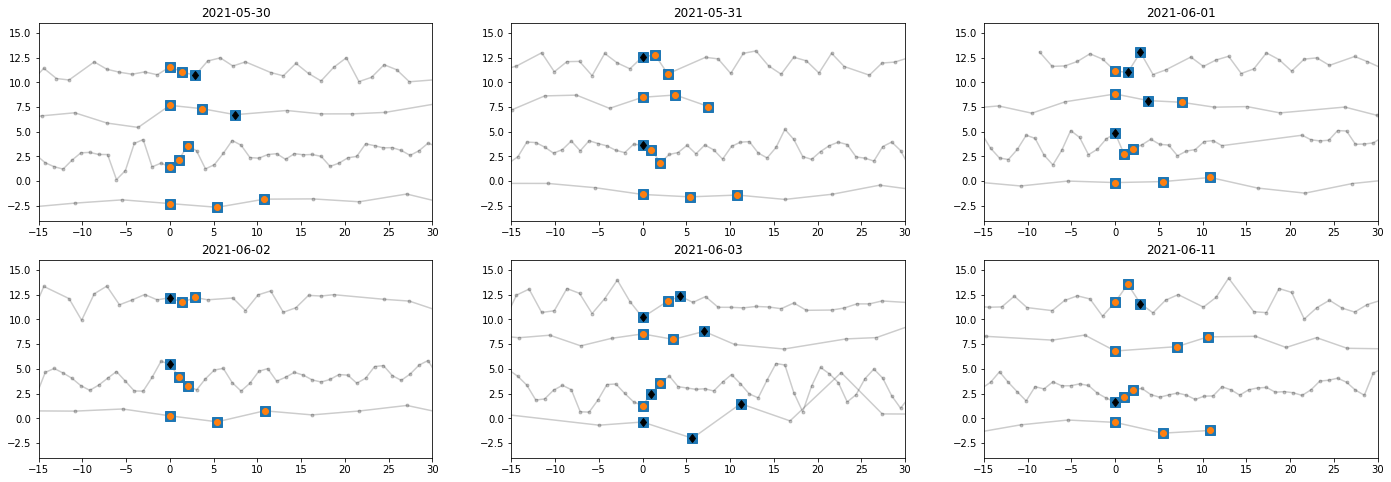

In [15]:
tvTestPlot('Nperiodic',(5.4/60/24,1.5/60/24))

### Masking out large periods of time
Not a function, but here's some code that I could help guide what to mask out

7.0
3005 out of 11165


(-7.5, 7.5)

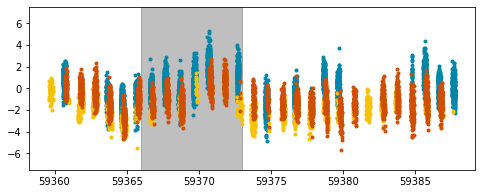

In [16]:
tmin, tmax = Time(['2021-06-01','2021-06-08']).mjd
print(tmax-tmin)
all_t = np.concatenate([df_dict[inst]['Time [MJD]'].to_numpy() for inst in instruments])
print(np.sum((all_t>=tmin) & (all_t<=tmax)),'out of',len(all_t))

plt.figure(figsize=(8,3))
for iinst,inst in enumerate(instruments):
    plt.plot(*df_dict[inst].loc[:, ["Time [MJD]","RV [m/s]"]].to_numpy().T,'.',color=inst_cols[iinst])
plt.fill_between([tmin,tmax],-10,10,color='k',alpha=0.25)
plt.ylim(-7.5,7.5)

### Matching EXPRES/NEID Time Periods
The training/validation code is built into this function.  If the code passed the tests above it should pass this, but we'll run through some quick examples here just to make sure it's integrated properly.

Here we'll only test `Npercent` and `NperDay` b/c I don't currently envision using any other options.

#### `Npercent`

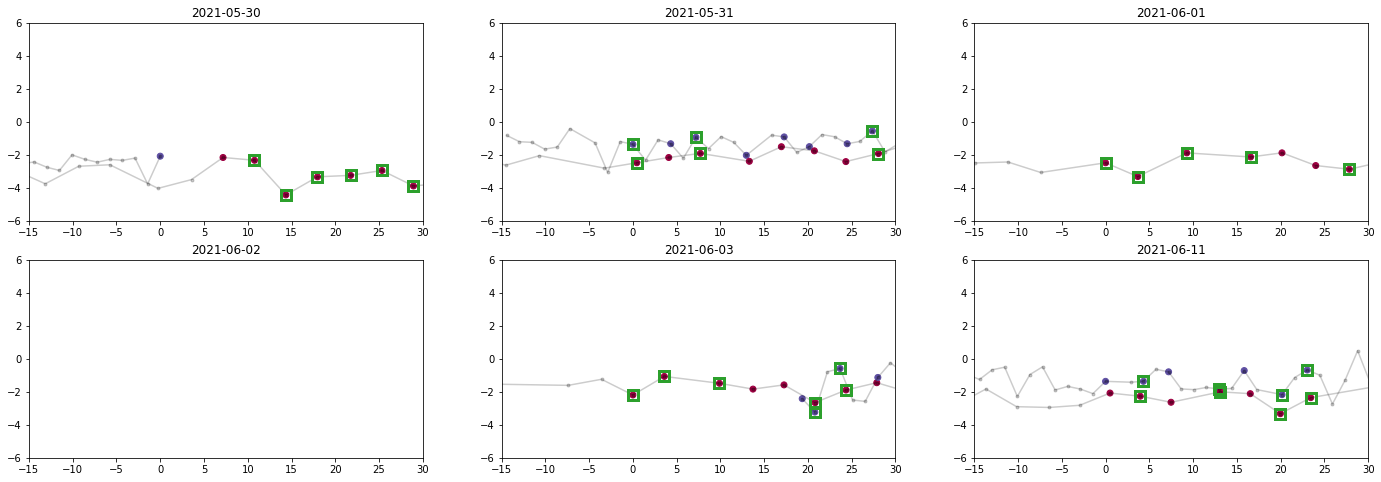

In [17]:
expresNeidTestPlot(num_obs=10,valid_mode='Npercent',num_valid=.5)

#### `Nperday`

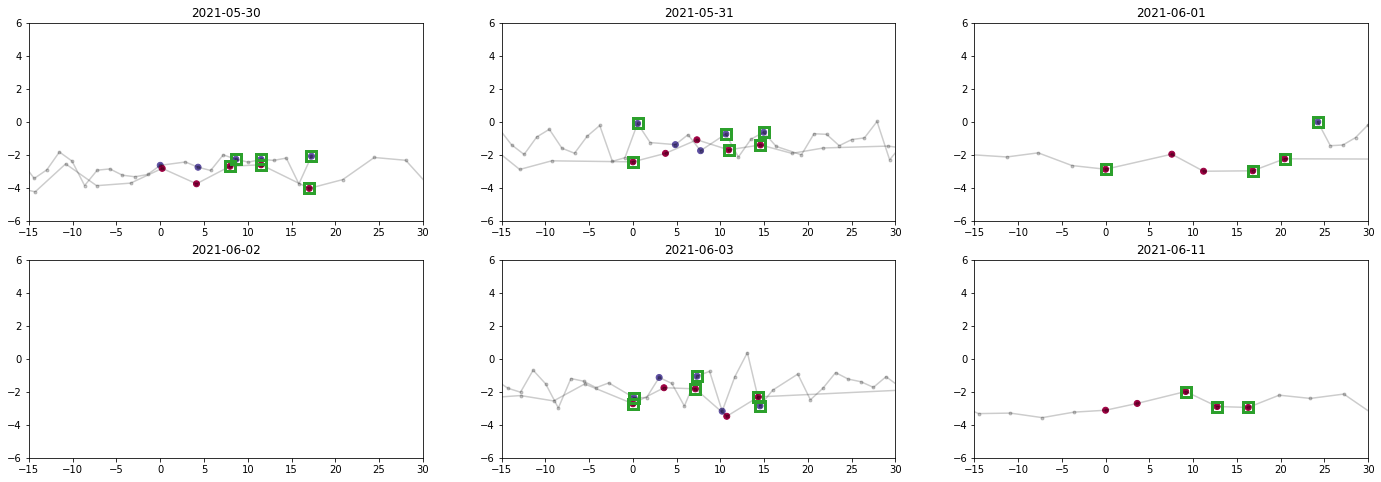

In [18]:
expresNeidTestPlot(num_obs=5,valid_mode='Nperday',num_valid=2)

## Generating a Data Set
To test `mkDataSet`, the script where it all comes together, we generate a summary file of an example data set.

In [50]:
def getStandardFile(data_set,iobs,inst):
    iobs = str(iobs)
    while len(iobs)!=3:
        iobs = '0'+iobs
    return f'{data_set}_{iobs}_{inst}.fits'

def getObs(data_set,num_obs,target_expt=0,
           validation_mode='',validation_amount=None):
    ### Select Observations for Data Set
    df_list = []
    for iinst,inst in enumerate(instruments):
        inst_df = pd.read_csv(os.path.join(solar_dir,f'{inst}_drp.csv'))
        
        # Select Observations
        if target_expt==0: # no averaging of observations needed
            obs_mask = downSelectTimes(inst_df,num_obs=num_obs)
        else:
            obs_indx = getFilesToAverage(inst_df, target_expt=args.target_expt,num_obs=tot_obs)
            #!!!!# INSERT CODE TO AVERAGE OBSERVATIONS HERE ONCE WRITTEN
            return
        
        inst_df['Instrument'] = instruments[iinst]
        inst_ds_df = inst_df[obs_mask].copy()
        
        # Define Training/Validation Sets
        if len(validation_mode)>0:
            # For periodic validation, we mask after combining data from all instruments
            if validation_mode.lower() != 'nperiodic':
                train_mask = selectValidationSet(inst_ds_df,
                                                 mode=validation_mode,
                                                 validation_amount=validation_amount)
        else:
            train_mask = np.ones(np.sum(obs_mask),dtype=bool)
        
        inst_ds_df['Training'] = train_mask.copy()
        
        df_list.append(inst_ds_df)
    
    
    ### Generate File Describing Data Set Files
    ds_df = pd.concat(df_list).sort_values(by='Time [MJD]').reset_index() # combine info from all four instruments
    new_names = [getStandardFile(data_set,iobs,ds_df.at[iobs,'Instrument']) for iobs in range(len(ds_df))]
    ds_df['Standard File Name'] = new_names
    # Define Periodic T/V Set Here so Data From All Instruments are Masked in Same Way
    if (validation_mode.lower() == 'nperiodic'):
        ds_df['Training'] = selectValidationSet(inst_df[obs_mask],
                                                mode=validation_mode,
                                                validation_amount=validation_amount)
    
    for key in ['index','Quality','Start Time [MJD]']:
        if key in ds_df.columns:
            del ds_df[key]
    # Save Summary File
    ds_df.to_csv(os.path.join(solar_dir,'DataSets',f'{data_set}.csv'))
    
    return ds_df

In [51]:
def dsTestPlot(ds_df,days=days):
    fig, axes = getAxes(days)

    for iinst,inst in enumerate(instruments):
        inst_df = pd.read_csv(os.path.join(solar_dir,f'{inst}_drp.csv'))
        inst_t, inst_v = inst_df.loc[:, ["Time [MJD]","RV [m/s]"]].to_numpy().T
        inst_v -= np.nanmedian(inst_v)
        
        data_df = ds_df[ds_df['Instrument']==inst]
        time, rvel = data_df.loc[:, ["Time [MJD]","RV [m/s]"]].to_numpy().T
        rvel -= np.nanmedian(rvel)
        tint = time.astype(int)
        
        train_mask = data_df['Training']
        valid_mask = ~train_mask

        for iday,d in enumerate(days):
            ax = axes[iday]
            d_mask = tint==d
            
            # I want to anchor these to the span of selected observations
            if np.sum(d_mask)>0:
                time0 = min(time[d_mask])
                # Plot All Observation
                ax.plot((inst_t-time0)*24*60,inst_v+iinst*4,'k.-',alpha=0.2)
                # Plot Selected Observations
                ax.plot((time-time0)*24*60,rvel+iinst*4,'C0s',ms=10)
                # Plot Training Observation
                ax.plot((time[train_mask]-time0)*24*60,rvel[train_mask]+iinst*4,'C1o')
                # Plot Validation Observation
                ax.plot((time[valid_mask]-time0)*24*60,rvel[valid_mask]+iinst*4,'kd')

    for ax in axes:
        ax.set_xlim(-15,30)

In [52]:
ds_df = getObs('TEST',3,target_expt=0,
               validation_mode='',validation_amount=None)
ds_df

File Name    Time [MJD]    RV [m/s]  \
0                          Sun_210525.5121.fits  59359.754140   -1.046855   
1                          Sun_210525.5123.fits  59359.759030   -1.061131   
2                          Sun_210525.5124.fits  59359.761469   -1.175769   
3    r.HARPN.2021-05-26T10-02-24.138_S2D_A.fits  59360.415020  100.826917   
4    r.HARPN.2021-05-26T10-07-49.253_S2D_A.fits  59360.418785  101.044992   
..                                          ...           ...         ...   
256  r.HARPN.2021-06-22T13-41-36.993_S2D_A.fits  59387.567259  100.954774   
257  r.HARPN.2021-06-22T13-47-01.346_S2D_A.fits  59387.571016  100.167332   
258  r.HARPS.2021-06-22T16:59:43.514_S2D_A.fits  59387.703276    1.143333   
259  r.HARPS.2021-06-22T17:00:44.367_S2D_A.fits  59387.703981    2.290517   
260  r.HARPS.2021-06-22T17:01:45.340_S2D_A.fits  59387.704686    2.316729   

     RV Err. [m/s]  Exp. Time [s]   Airmass    BERV [km/s] Instrument  \
0         0.181754     169.692001  1.067494 -833107.491215     expres   
1         0.176260     170.656998  1.059926 -843581.419347     expres   
2         0.176298     171.917007  1.056484 -848839.396947     expres   
3         0.297041     300.000000  1.345421            NaN     harpsn   
4         0.299046     300.000000  1.320948            NaN     harpsn   
..             ...            ...       ...            ...        ...   
256       0.283193     300.000000  1.011302            NaN     harpsn   
257       0.282871     300.000000  1.014156            NaN     harpsn   
258       0.285221      29.996500  1.654205            NaN      harps   
259       0.285282      29.996500  1.654847            NaN      harps   
260       0.285373      29.996500  1.655534            NaN      harps   

     Training         Standard File  
0        True  TEST_000_expres.fits  
1        True  TEST_001_expres.fits  
2        True  TEST_002_expres.fits  
3        True  TEST_003_harpsn.fits  
4        True  TEST_004_harpsn.fits  
..        ...                   ...  
256      True  TEST_256_harpsn.fits  
257      True  TEST_257_harpsn.fits  
258      True   TEST_258_harps.fits  
259      True   TEST_259_harps.fits  
260      True   TEST_260_harps.fits  

[261 rows x 10 columns]

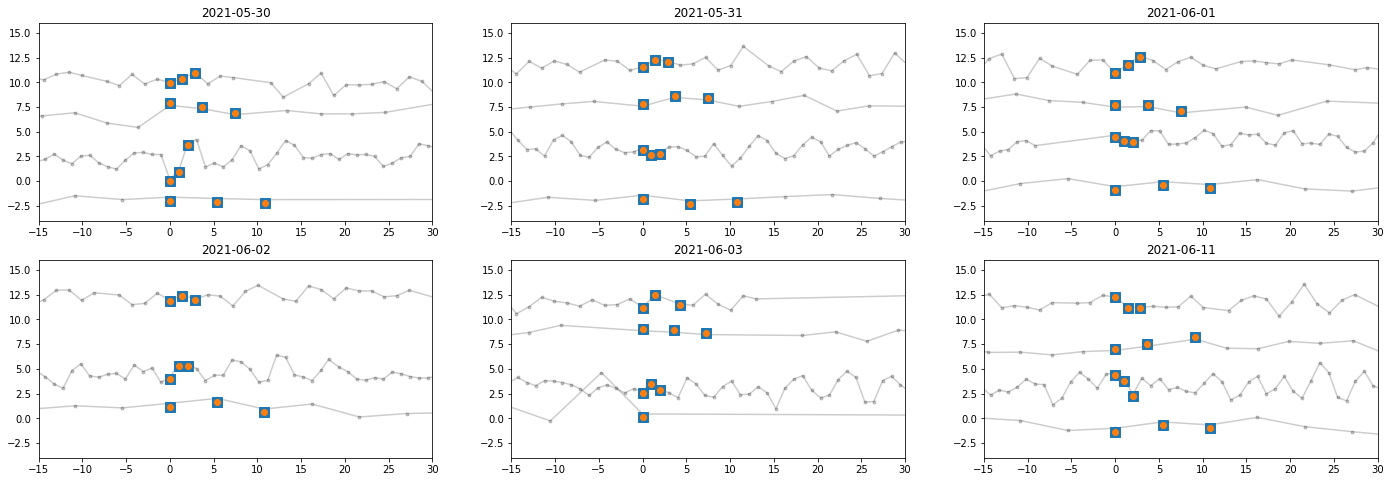

In [45]:
dsTestPlot(ds_df)

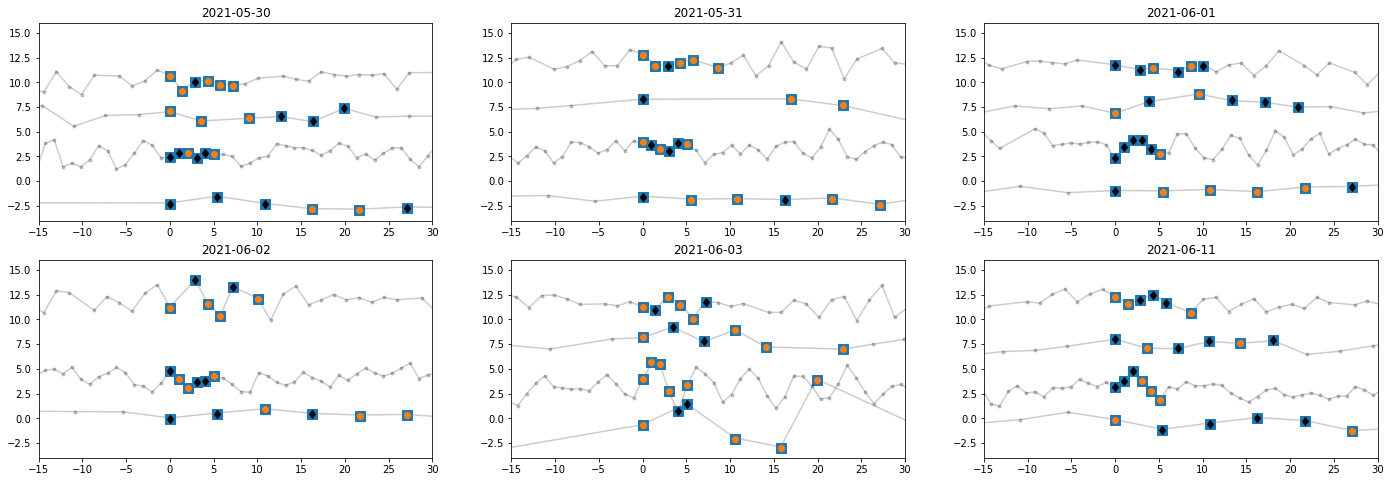

In [47]:
ds_df = getObs('TEST',6,target_expt=0,
               validation_mode='Npercent',validation_amount=.5)
dsTestPlot(ds_df)

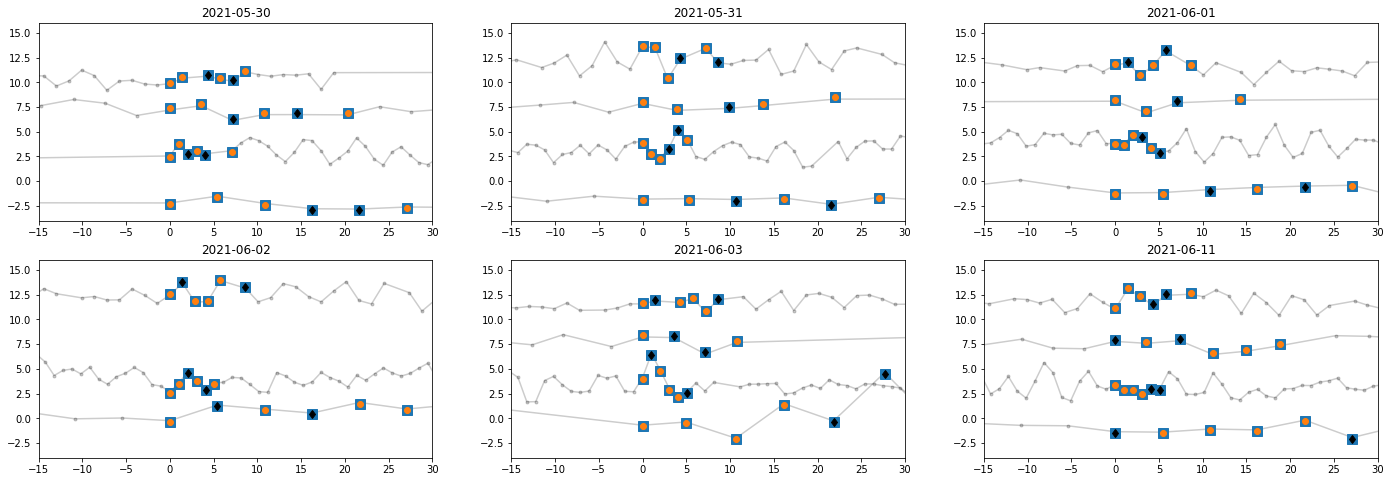

In [48]:
ds_df = getObs('TEST',6,target_expt=0,
               validation_mode='Nperday',validation_amount=2)
dsTestPlot(ds_df)